In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Calculating the relative hydration energy of NaCl to water

## View trace of energy and gradient

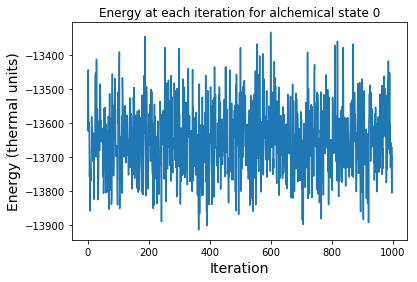

In [23]:
state = 0
energy = np.load('state_{0}/alchemical_energies.npy'.format(state))

plt.plot(energy[1:,state])
plt.title('Energy at each iteration for alchemical state {0}'.format(state))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy (thermal units)', fontsize=14)
plt.show()

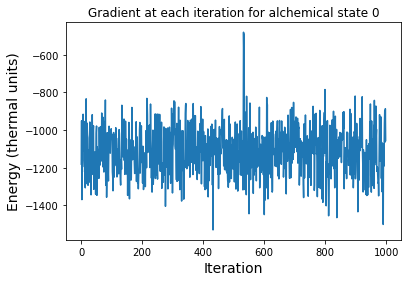

In [24]:
state = 0
gradient = np.load('state_{0}/alchemical_grads.npy'.format(state))

plt.plot(gradient[1:,state])
plt.title('Gradient at each iteration for alchemical state {0}'.format(state))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Energy (thermal units)', fontsize=14)
plt.show()

## Calculating the relative hydration free energy with MBAR

Unpacking the simulation data

In [43]:
nstates = 20
niterations = 999

u_kln = np.zeros([nstates, nstates, niterations], np.float64)

for k in range(nstates):
    energies = np.load('state_{0}/alchemical_energies.npy'.format(state))[1:,:]
    u_kln[k,:,:] = energies.T

Calculating the MBAR free energy.

In [93]:
from pymbar import MBAR, timeseries

# Subsample data to extract uncorrelated equilibrium timeseries
N_k = np.zeros([nstates], np.int32) # number of uncorrelated samples
for k in range(nstates):
    [nequil, g, Neff_max] = timeseries.detectEquilibration(u_kln[k,k,:])
    indices = timeseries.subsampleCorrelatedData(u_kln[k,k,:], g=g)
    N_k[k] = len(indices)
    u_kln[k,:,0:N_k[k]] = u_kln[k,:,indices].T
# Compute free energy differences and statistical uncertainties
mbar = MBAR(u_kln, N_k)
[DeltaF_ij, dDeltaF_ij, Theta_ij] = mbar.getFreeEnergyDifferences()

print('Relative TI free energy = {0} +/- {1}'.format(DeltaF_ij[0,:][-1], dDeltaF_ij[0,:][-1]))

Relative TI free energy = -845.4363376423368 +/- 0.12424552781272047


In kcal/mol:

In [100]:
DeltaF_ij[0,:][-1]*0.592

-500.49831188426333

## Calculating the relative hydration free energy with TI

In [83]:
nstates=20
ninterations = 999

gradients = np.zeros((nstates, ninterations))
for state in range(nstates):
    gradients[state,:] = np.load('state_{0}/alchemical_grads.npy'.format(state))[1:, state]

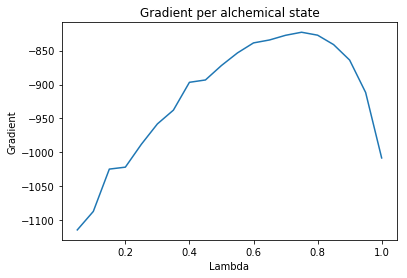

In [75]:
g_means = np.mean(gradients, axis=1)
l = np.arange(1.0, 21.0, 1.0) / 20.0

plt.plot(l, g_means)
plt.title('Gradient per alchemical state')
plt.xlabel('Lambda')
plt.ylabel('Gradient')
plt.show()

Estimate the TI free energy and error with bootstrap sampling

In [89]:
nboots = 100

free_energies = np.zeros(nboots)
for b in range(nboots):
    boot_samps = np.zeros((nstates, ninterations))
    for state in range(nstates):
        boot_samps[state,:] = np.random.choice(gradients[state,:], size=ninterations, replace=True)
    boot_mean = np.mean(boot_samps, axis=1)
    free_energies[b] = np.trapz(y=boot_mean, x=l)

print('Relative TI free energy = {0} +/- {1}'.format(free_energies.mean(), free_energies.std()))

Relative free energy = -868.029800507937 +/- 0.5793406097752878


In kcal/mol:

In [101]:
free_energies.mean()*0.598

-519.0818207037463

## Estimating the thermodynamic length of the path

In [9]:
nstates=20
l = np.arange(1.0, 21.0, 1.0) / 20.0

gradients = np.zeros((nstates, f-i))
fisher = np.zeros(nstates)
for state in range(nstates):
    g = np.load('state_{0}/alchemical_grads.npy'.format(state))[i:, state]
    gradients[state,:] = g
    fisher[state] = np.var(g)
    if g.mean() == 0:
        print(state)
    #energies = np.load('state_{0}/alchemical_grads.npy'.format(state))[i:f,state]

In [104]:
np.diff(l)[0]

0.050000000000000003

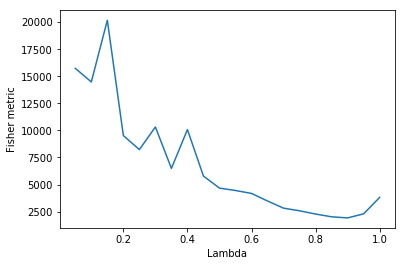

In [106]:
plt.plot(l, fisher)
plt.ylabel('Fisher metric')
plt.xlabel('Lambda')
plt.show()

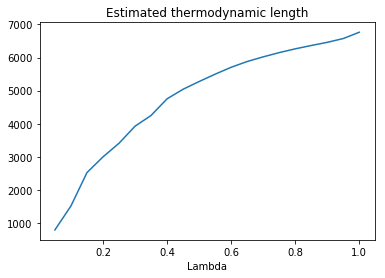

In [105]:
plt.plot(l, np.diff(l)[0] * np.cumsum(fisher))
plt.title('Estimated thermodynamic length')
plt.xlabel('Lambda')
plt.show()